In [1]:
import json
import csv
import requests
import boto3

BUCKET_NAME = "datastorageforlabs"

def convert_json_to_csv(json_data, csv_file):
    data = json.loads(json_data)
    header = list(data[0].keys())

    with open(csv_file, 'w', newline='', encoding="utf-8") as file:
        writer = csv.DictWriter(file, fieldnames=header)
        writer.writeheader()
        writer.writerows(data)

types = ("usd", "eur")
s3 = boto3.client("s3")

for i in types:
    response = requests.get(f"https://bank.gov.ua/NBU_Exchange/exchange_site?start=20210101&end=20211231&valcode={i}&sort=exchangedate&order=desc&json")
    convert_json_to_csv(response.text, f"{i}.csv")
    s3.upload_file(f"{i}.csv", BUCKET_NAME, f"{i}.csv")

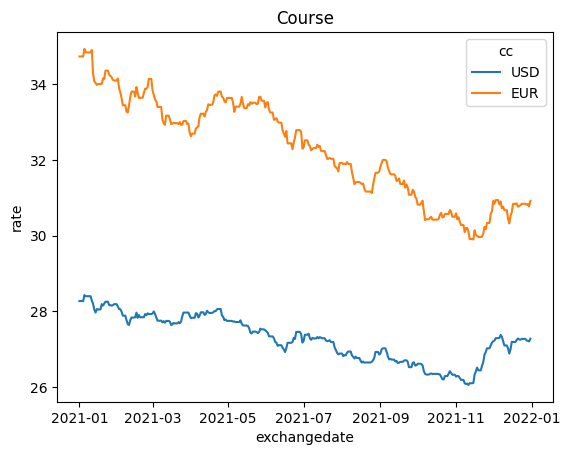

In [13]:
import io
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

df = pd.DataFrame()

for i in types:
    response = s3.get_object(Bucket=BUCKET_NAME, Key=f"{i}.csv")
    file_content = response['Body'].read().decode("utf-8")
    temp_df = pd.read_csv(io.StringIO(file_content))
    df = pd.concat([df, temp_df], axis=0)

df["exchangedate"] = pd.to_datetime(df["exchangedate"], format="%d.%m.%Y")
df = df.sort_values("exchangedate")

plt.title("Course")
sns.lineplot(x=df["exchangedate"], y=df["rate"], hue=df["cc"])
plt.savefig("course.png")
plt.show()

In [14]:
s3.upload_file("course.png", BUCKET_NAME, "course.png")